In [1]:
<span style="color:red">이 텍스트는 빨간색입니다.</span>

SyntaxError: invalid syntax (3403352944.py, line 1)

# <span style="color:blue"> HuggingFace 커스텀 프로젝트 만들기 </span>

model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task를 도전

---

## 0. 라이브러리 불러오기

---

In [2]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


## 1. NSMC 데이터 분석 및 Huggingface dataset 구성

데이터셋은 깃허브에서 다운받거나, Huggingface datasets에서 가져올 수 있습니다. 앞에서 배운 방법들을 활용해봅시다!

---

In [3]:
import datasets
from datasets import load_dataset

huggingface_mrpc_dataset = load_dataset('nsmc', 'SST-2')
print(huggingface_mrpc_dataset)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration SST-2


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/SST-2/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


### <span style="color:red">출력 결과 해석 및 데이터 분석.</span>
**train**: id(식별 번호), document(영화 리뷰 내용), label(긍정=1, 부정=0), 15만개 <br>
**test** : train과 동일하며 5만개

In [4]:
train = huggingface_mrpc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [5]:
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




In [6]:
import pandas as pd

# Dataset을 pandas DataFrame으로 변환
train_df = pd.DataFrame(train)

In [7]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
# document 열에서 중복된 데이터 확인
duplicate_count = train_df['document'].duplicated().sum()

print("document 열에서 중복된 데이터 개수:", duplicate_count)

document 열에서 중복된 데이터 개수: 3817


In [9]:
# document 열에서 중복된 데이터 확인
duplicate_count = train_df['id'].duplicated().sum()

print("document id에서 중복된 데이터 개수:", duplicate_count)

document id에서 중복된 데이터 개수: 0


In [10]:
# document 열을 기준으로 중복된 행 제거 (첫 번째 중복만 남김)
train_df = train_df.drop_duplicates(subset=['document'])

# 중복 제거 후 남은 데이터 수 확인
remaining_data_count = len(train_df)
print("남은 데이터 수:", remaining_data_count)

남은 데이터 수: 146183


In [11]:
# DataFrame을 다시 Dataset 객체로 변환 (필요한 경우)
#from datasets import Dataset
#train = Dataset.from_pandas(train_df)


In [12]:
# 각 열에 누락값이 있는지 확인
missing_values = train_df.isnull().sum()

# 누락값이 있는 열과 그 개수 출력
print("누락값이 있는 열과 개수:")
print(missing_values[missing_values > 0])


누락값이 있는 열과 개수:
Series([], dtype: int64)


In [13]:
# document 열의 평균 글자 수 계산
average_length = train_df['document'].apply(len).mean()

print("document 열의 평균 글자 수:", average_length)


document 열의 평균 글자 수: 35.98109219266262


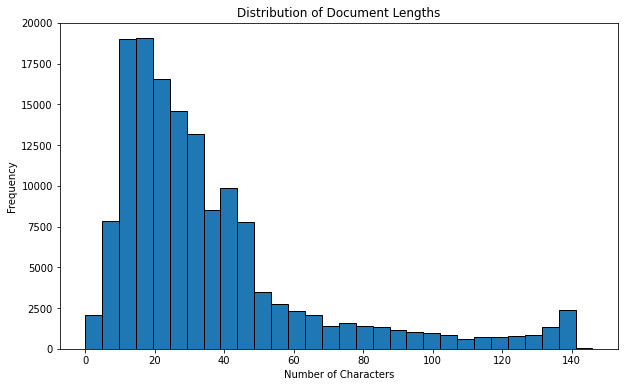

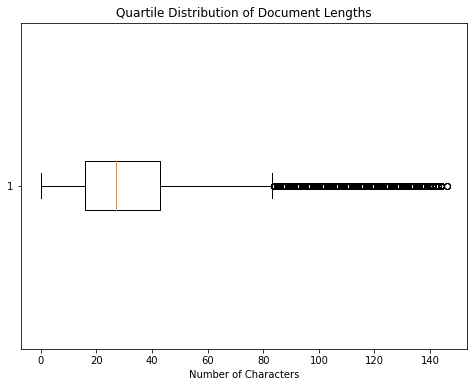

In [14]:
import matplotlib.pyplot as plt

# 각 행별 'document' 열의 글자 수 계산
train_df['doc_length'] = train_df['document'].apply(len)

# 막대그래프: 글자 수 분포
plt.figure(figsize=(10, 6))
plt.hist(train_df['doc_length'], bins=30, edgecolor='black')
plt.title('Distribution of Document Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# 사분위 그래프(상자 그림) 생성
plt.figure(figsize=(8, 6))
plt.boxplot(train_df['doc_length'], vert=False)
plt.title('Quartile Distribution of Document Lengths')
plt.xlabel('Number of Characters')
plt.show()


In [15]:
# 글자 수가 10에서 20자 사이인 데이터만 필터링
train_df_1 = train_df[train_df['document'].apply(len).between(10, 20)]

# 필터링 후 데이터 수 확인
print("남은 데이터 수:", len(train_df_1))

남은 데이터 수: 41586


In [16]:
# 각 글자 수 구간에 해당하는 데이터 10개씩 출력
ranges = [(10, 12), (13, 15), (16, 18), (19, 21)]

for start, end in ranges:
    print(f"\n글자 수 {start}-{end}자 사이인 데이터 10개:")
    filtered_data = train_df[train_df['document'].apply(len).between(start, end)].head(10)
    print(filtered_data[['document','label']])



글자 수 10-12자 사이인 데이터 10개:
         document  label
59    백봉기 언제나오나요?      1
77     매우 실망.....      0
79   아햏햏 아햏햏 아햏햏.      1
81   단연 최고라고 할수있지      1
84     정말쓰레기영화입니다      0
87     내일이 기대되는 `      1
96     재미있는영화입니다.      1
132   아주 모자라진 않다.      0
145  용가리 진짜짱짱맨이다ㅋ      0
153  나름 괜찮은 작품입니다      1

글자 수 13-15자 사이인 데이터 10개:
            document  label
74    어설픈 전개 어이없는 결말      0
85     진정 위대한 영화 최고임      1
90     성룡영화중 최악인듯 ㅋㅋ      0
97     클라라볼라고화신본거아닌데      0
107   크리스마스하면 떠오르는영화      1
119   절대 보지마라 쓰레기 영화      0
131   베댓이 말을 아주 잘써놨네      1
144  재미있다고 허풍 떨지 마세요      0
162    오랜만에 재밋는영화봤네요      1
173  게이물인줄 모르고 봤네...      0

글자 수 16-18자 사이인 데이터 10개:
              document  label
2    너무재밓었다그래서보는것을추천한다      0
10    걍인피니트가짱이다.진짜짱이다♥      1
15    ㄱ냥 매번 긴장되고 재밋음ㅠㅠ      1
21   보면서 웃지 않는 건 불가능하다      1
24   주제는 좋은데 중반부터 지루하다      0
26  kl2g 고추를 털어버려야 할텐데      1
32    재밌는데 별점이 왜이리 낮은고      1
35  패션에 대한 열정! 안나 윈투어!      1
40    단순하면서 은은한 매력의 영화      1
42   오게두어라! 서리한이 굶주렸다!      1

글자 수 19-

In [17]:
import pandas as pd

# 글자 수가 13자에서 20자 사이인 데이터 필터링
filtered_df = train_df[train_df['document'].apply(len).between(13, 20)]

# 4,000개를 랜덤으로 샘플링
train_df_2 = filtered_df.sample(n=4000, random_state=42)  # random_state를 고정하여 매번 동일한 샘플 추출

# 샘플링 후 데이터 수 확인
print("랜덤으로 선택된 데이터 수:", len(train_df_2))


랜덤으로 선택된 데이터 수: 4000


In [18]:
from datasets import Dataset, DatasetDict

# train_df_2를 Dataset 형식으로 변환
hf_train_dataset = Dataset.from_pandas(train_df_2)

# DatasetDict 객체로 변환하여 'train'에 저장
hf_dataset = DatasetDict({'train': hf_train_dataset})

# 저장 확인
print("hf_dataset['train'] 데이터 수:", len(hf_dataset['train']))


hf_dataset['train'] 데이터 수: 4000


In [19]:
# 'test' 데이터셋의 원래 개수 출력
test_size = len(huggingface_mrpc_dataset['test'])
print("테스트 데이터 개수:", test_size)

테스트 데이터 개수: 50000


In [20]:
# 테스트 데이터셋을 1,000개로 줄이기
hf_test_dataset = huggingface_mrpc_dataset['test'].select(range(5000))

# 줄인 데이터 개수 확인
print("줄인 테스트 데이터 개수:", len(hf_test_dataset))

줄인 테스트 데이터 개수: 5000


In [21]:
from datasets import DatasetDict

# train 데이터셋과 1,000개로 줄인 테스트 데이터셋을 포함하는 DatasetDict 생성
hf_dataset = DatasetDict({
    'train': hf_train_dataset,       # 이미 정의된 훈련 데이터셋
    'test': hf_test_dataset          # 1,000개로 줄인 테스트 데이터셋
})

# 확인
print("훈련 데이터 개수:", len(hf_dataset['train']))
print("테스트 데이터 개수:", len(hf_dataset['test']))


훈련 데이터 개수: 4000
테스트 데이터 개수: 5000


## 2. klue/bert-base model 및 tokenizer 불러오기

---

In [22]:
import transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

# 모델 및 토크나이저 설정 완료

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

## 3. 불러온 tokenizer로 데이터셋 전처리 및 model 학습 진행

데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

---

## 실험1. 전처리만 하기

In [27]:
from transformers import TrainerCallback
from transformers import Trainer, TrainingArguments
import numpy as np
import os

# Custom Callback 정의
class LogMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # 매 epoch이 끝날 때마다 훈련 데이터셋에서 accuracy, f1, loss 계산
        results = trainer.predict(hf_train_dataset)
        acc = results.metrics["test_accuracy"]
        f1 = results.metrics["test_f1"]
        loss = results.metrics["test_loss"]
        print(f"Epoch {int(state.epoch)}: Loss = {loss:.4f}, Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

# transform 함수 수정
def transform(data):
    tokens = tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )
    return {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }

# 데이터셋에 transform 함수 적용
hf_train_dataset = hf_dataset['train'].map(transform, batched=True)
hf_test_dataset = hf_dataset['test'].map(transform, batched=True)

# TrainingArguments 및 Trainer 초기화
output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="no",  # 검증 데이터셋 없이 훈련
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,  # 로그 빈도 설정
)

from datasets import load_metric

# accuracy와 f1 메트릭 로드
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

# compute_metrics 함수 정의
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    compute_metrics=compute_metrics,
    callbacks=[LogMetricsCallback()]  # Custom Callback 추가
)

# 모델 학습 시작
trainer.train()
print("슝~")


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_length, id, document.
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
500,0.433700
1000,0.258300
1500,0.148800


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_length, id, document.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 1: Loss = 0.2005, Accuracy = 0.9243, F1 Score = 0.9242


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_length, id, document.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 2: Loss = 0.1086, Accuracy = 0.9670, F1 Score = 0.9670


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_length, id, document.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




Epoch 3: Loss = 0.0795, Accuracy = 0.9792, F1 Score = 0.9792
슝~


### 실험1. predict 결과
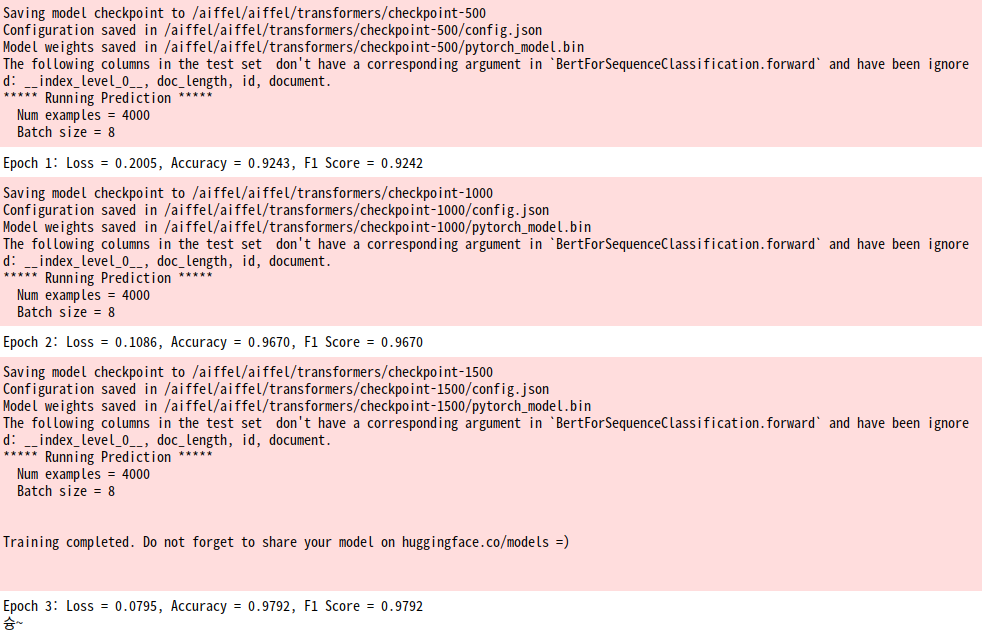

In [ ]:
trainer.evaluate(hf_test_dataset)

### 실험 1. 훈련 결과 acc: 0.8632

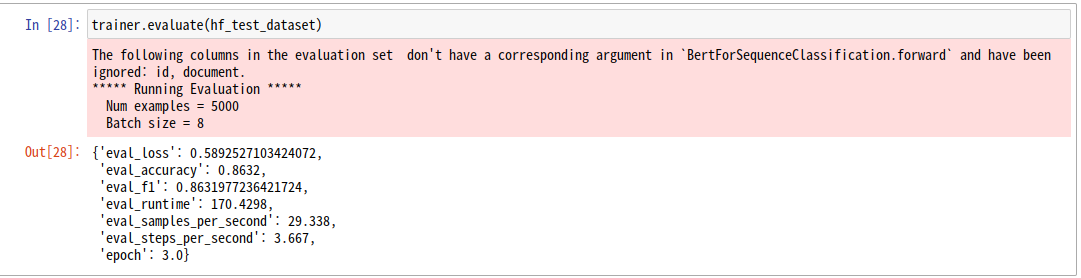

데이터갯수 9만개까지 줄이기
-> 중복제거, 맥스렌 20 등등
모델 건드려보는 것도 좋음(융님)
멀티헤드어텐션에서 레이어 개수 줄이거나 풀리커넥티트 부분 줄이면 더 빨라짐

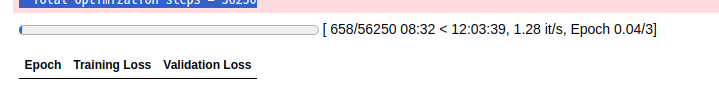

### accident!
15만개의 데이터셋을 전처리 없이 사용 시 1 epoch 당 11시간 이상이 소요됨 -> 중복제거, 누락값 처리, max_length 제한 등의 전처리 필요!

In [29]:
# 모델의 전체 레이어 수 확인
total_layers = len(model.bert.encoder.layer)
print("모델의 전체 레이어 수:", total_layers)


모델의 전체 레이어 수: 12


In [30]:
# 모델 구조 출력
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 실험2. 하위레이어 6층을 동결시켜보기

In [27]:
from transformers import TrainerCallback
from transformers import Trainer, TrainingArguments
import numpy as np
import os

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

# 모델의 하위 절반 레이어 동결
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# Custom Callback 정의
class LogMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # 매 epoch이 끝날 때마다 훈련 데이터셋에서 accuracy, f1, loss 계산
        results = trainer.predict(hf_train_dataset)
        acc = results.metrics["test_accuracy"]
        f1 = results.metrics["test_f1"]
        loss = results.metrics["test_loss"]
        print(f"Epoch {int(state.epoch)}: Loss = {loss:.4f}, Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

# transform 함수 수정
def transform(data):
    tokens = tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )
    return {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }

# 데이터셋에 transform 함수 적용
hf_train_dataset = hf_dataset['train'].map(transform, batched=True)
hf_test_dataset = hf_dataset['test'].map(transform, batched=True)

# TrainingArguments 및 Trainer 초기화
output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="no",  # 검증 데이터셋 없이 훈련
    learning_rate=2e-5,
    per_device_train_batch_size=9,
    per_device_eval_batch_size=9,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,  # 로그 빈도 설정
)

from datasets import load_metric

# accuracy와 f1 메트릭 로드
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

# compute_metrics 함수 정의
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    compute_metrics=compute_metrics,
    callbacks=[LogMetricsCallback()]  # Custom Callback 추가
)

# 모델 학습 시작
trainer.train()
print("슝~")


loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_length, __index_level_0__, document, id.
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 9
  Total train batch size (w. parallel, distributed & accumulation) = 9
  Gradient Accumulation steps = 1
  Total optimization steps = 1335


Step,Training Loss
500,0.429100
1000,0.285700


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_length, __index_level_0__, document, id.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 9


Epoch 1: Loss = 0.2669, Accuracy = 0.8922, F1 Score = 0.8922


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_length, __index_level_0__, document, id.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 9


Epoch 2: Loss = 0.1811, Accuracy = 0.9367, F1 Score = 0.9367


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_length, __index_level_0__, document, id.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 9


Training completed. Do not forget to share your model on huggingface.co/models =)




Epoch 3: Loss = 0.1584, Accuracy = 0.9497, F1 Score = 0.9497
슝~


In [29]:
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 9


{'eval_loss': 0.436534583568573,
 'eval_accuracy': 0.8642,
 'eval_f1': 0.864202189180152,
 'eval_runtime': 167.7552,
 'eval_samples_per_second': 29.805,
 'eval_steps_per_second': 3.314,
 'epoch': 3.0}

## 실험3. 파라미터 조절해보기

In [23]:
from transformers import TrainerCallback
from transformers import Trainer, TrainingArguments
import numpy as np
import os

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

# 모델의 하위 절반 레이어 동결
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# Custom Callback 정의
class LogMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # 매 epoch이 끝날 때마다 훈련 데이터셋에서 accuracy, f1, loss 계산
        results = trainer.predict(hf_train_dataset)
        acc = results.metrics["test_accuracy"]
        f1 = results.metrics["test_f1"]
        loss = results.metrics["test_loss"]
        print(f"Epoch {int(state.epoch)}: Loss = {loss:.4f}, Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

# transform 함수 수정
def transform(data):
    tokens = tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )
    return {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }

# 데이터셋에 transform 함수 적용
hf_train_dataset = hf_dataset['train'].map(transform, batched=True)
hf_test_dataset = hf_dataset['test'].map(transform, batched=True)

# TrainingArguments 및 Trainer 초기화
output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="no",  # 검증 데이터셋 없이 훈련
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=500,  # 로그 빈도 설정
)

from datasets import load_metric

# accuracy와 f1 메트릭 로드
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

# compute_metrics 함수 정의
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    compute_metrics=compute_metrics,
    callbacks=[LogMetricsCallback()]  # Custom Callback 추가
)

# 모델 학습 시작
trainer.train()
print("슝~")


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running training *****
  Num examples = 4000
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


Step,Training Loss
500,0.460700
1000,0.345200
1500,0.285700
2000,0.229300
2500,0.179300
3000,0.141800
3500,0.104700
4000,0.094600
4500,0.083000
5000,0.064100


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 1: Loss = 0.3067, Accuracy = 0.8718, F1 Score = 0.8717


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 2: Loss = 0.2167, Accuracy = 0.9220, F1 Score = 0.9220


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 3: Loss = 0.1636, Accuracy = 0.9455, F1 Score = 0.9455


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 4: Loss = 0.1353, Accuracy = 0.9630, F1 Score = 0.9630


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 5: Loss = 0.0977, Accuracy = 0.9768, F1 Score = 0.9767


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-3000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 6: Loss = 0.0705, Accuracy = 0.9822, F1 Score = 0.9822


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-3500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 7: Loss = 0.0513, Accuracy = 0.9880, F1 Score = 0.9880


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-4000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-4000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-4000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 8: Loss = 0.0367, Accuracy = 0.9918, F1 Score = 0.9917


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-4500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-4500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-4500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 9: Loss = 0.0336, Accuracy = 0.9930, F1 Score = 0.9930


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-5000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-5000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-5000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




Epoch 10: Loss = 0.0311, Accuracy = 0.9932, F1 Score = 0.9932
슝~


In [24]:
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


{'eval_loss': 0.8167899250984192,
 'eval_accuracy': 0.8602,
 'eval_f1': 0.8601913811804046,
 'eval_runtime': 169.3153,
 'eval_samples_per_second': 29.531,
 'eval_steps_per_second': 3.691,
 'epoch': 10.0}

## 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

In [ ]:
from transformers import TrainerCallback, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import numpy as np
import os
from datasets import load_metric

# 토크나이저와 모델 로드
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

# 모델의 하위 절반 레이어 동결
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# Custom Callback 정의
class LogMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # 매 epoch이 끝날 때마다 훈련 데이터셋에서 accuracy, f1, loss 계산
        results = trainer.predict(hf_train_dataset)
        acc = results.metrics["test_accuracy"]
        f1 = results.metrics["test_f1"]
        loss = results.metrics["test_loss"]
        print(f"Epoch {int(state.epoch)}: Loss = {loss:.4f}, Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

# transform 함수 정의
def transform(data):
    tokens = tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )
    return {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }

# 데이터셋에 transform 함수 적용
hf_train_dataset = hf_dataset['train'].map(transform, batched=True)
hf_test_dataset = hf_dataset['test'].map(transform, batched=True)

# DataCollatorWithPadding 초기화 (동적 패딩)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# TrainingArguments 설정
output_dir = os.getenv('HOME')+'/aiffel/transformers'
training_arguments = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="no",  # 검증 데이터셋 없이 훈련
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=500,  # 로그 빈도 설정
)

# accuracy와 f1 메트릭 로드
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

# compute_metrics 함수 정의
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_test_dataset,  # 검증 데이터셋을 설정할 경우
    data_collator=data_collator,  # 동적 패딩을 위해 data_collator 사용
    compute_metrics=compute_metrics,
    callbacks=[LogMetricsCallback()]  # Custom Callback 추가
)

# 모델 학습 시작
trainer.train()
print("슝~")


loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running training *****
  Num examples = 4000
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


Step,Training Loss
500,0.458000
1000,0.341100
1500,0.290200
2000,0.235900
2500,0.188700
3000,0.149000


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 1: Loss = 0.3059, Accuracy = 0.8730, F1 Score = 0.8730


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 2: Loss = 0.2155, Accuracy = 0.9207, F1 Score = 0.9207


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 3: Loss = 0.1622, Accuracy = 0.9470, F1 Score = 0.9470


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 4: Loss = 0.1516, Accuracy = 0.9587, F1 Score = 0.9587


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2500/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 5: Loss = 0.1000, Accuracy = 0.9738, F1 Score = 0.9737


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-3000/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id, doc_length, __index_level_0__.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8


Epoch 6: Loss = 0.0776, Accuracy = 0.9812, F1 Score = 0.9812


In [ ]:
trainer.evaluate(hf_test_dataset)

# 회고
디엘톤 때 사용해본 허깅페이스를 다시 제대로 학습해 볼 수 잇어서 유익했다.
데이터가 많아서 훈련 시간을 줄이고, 정확도를 높이기 위해서 총 3개의 분야(전처리 부분에서, 모델 레이어 부분에서, 패딩 부분에서 )
다양하게 실험을 할 수 있어서 재밌었다.